somewhere else, do:
```
source $LSSTSW/setup.csh
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
#setup -k -r .
setup -t b1898 -r .
setup -t b1898 meas_modelfit
scons
```

then you will want to add `$HOME/lsstsw/miniconda/lib/python2.7/site-packages` to your `PYTHONPATH` in order to be able to import `joblib` and friends.

now edit and run the code in here.

In [1]:
import sys
from collections import namedtuple

import numpy as np

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

import lmfit

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

def display2dArray(arr, title='Data', showBars=True):
    img = plt.imshow(arr, origin='lower', interpolation='none', cmap='gray' )
    plt.title(title)
    if showBars: plt.colorbar(img, cmap='gray')

def displayImage(image, showMasks=True, showVariance=False, showPsf=False, showBars=True, isPsf=False):
    plt.figure(figsize=(8, 2.5))
    plt.subplot(1, 3, 1)
    ma = image.getMaskedImage().getArrays()
    display2dArray(ma[0], title='Data', showBars=showBars)
    if showMasks:
        plt.subplot(1, 3, 2)
        display2dArray(ma[1], title='Masks', showBars=showBars)
    if showVariance and not showPsf:
        plt.subplot(1, 3, 3)
        display2dArray(ma[2], title='Variance', showBars=showBars)
    if showPsf:
        plt.subplot(1, 3, 3)
        display2dArray(image.getPsf().computeImage().getArray(), title='PSF', showBars=showBars)

In [2]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim
import lsst.meas.modelfit as measMF

100.0
2.0
1732.61


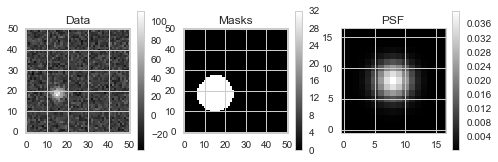

In [35]:
from lsst.meas.base.tests import TestDataset
#from meas_base_tests import TestDataset   ## my slightly modified version
import lsst.afw.geom as afwGeom

def makeStarImage_lsst(w=51, h=51, xc=15.3, yc=18.6, flux=2500, psfSigma=2., noise=1.0, schema=None):
    bbox = afwGeom.Box2I(afwGeom.Point2I(0,0), afwGeom.Point2I(w-1, h-1))
    dataset = TestDataset(bbox, psfSigma=psfSigma, threshold=1.)
    dataset.addSource(flux=flux, centroid=afwGeom.Point2D(xc, yc))
    if schema is None:
        schema = TestDataset.makeMinimalSchema()
    exposure, catalog = dataset.realize(noise=noise, schema=schema)
    return exposure, catalog

exposure, catalog = makeStarImage_lsst(flux=2500, noise=10.)
displayImage(exposure, showPsf=True)
print exposure.getMaskedImage().getArrays()[2].mean()
print exposure.getPsf().computeShape().getDeterminantRadius()
print exposure.getMaskedImage().getArrays()[0].sum()

The following is taken from `meas_modelfit/tests/testPsfFitter.py`

0 2 1
4.2901781515 3.88727078499 0.0983058678053
4.71
21676.4929451
((ixx=0.0204190890614, iyy=0.0324016779559, ixy=0.0127888974942), (1.0757, 0.10495))
((ixx=0.0208939248278, iyy=0.01109672584, ixy=0.0134601656493), (0.41044, 0.26349))
21541.2517296
((ixx=4.56003510531, iyy=0.0036202421179, ixy=-0.0233729786826), (0.46453, -1.0595))
((ixx=3.64067551147, iyy=0.00784166075401, ixy=-0.062750181421), (0.78962, -0.046979))
20636.9453915
((ixx=4.2901781515, iyy=3.88727078499, ixy=0.0983058678053), (0, 0))
((ixx=17.160712606, iyy=15.5490831399, ixy=0.393223471221), (0, 0))


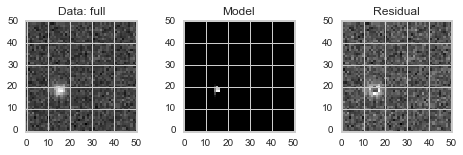

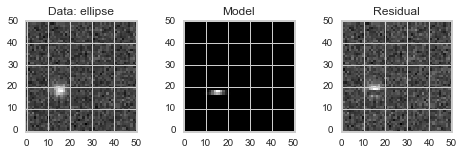

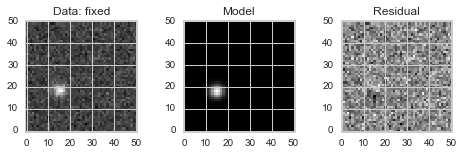

In [33]:
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
import lsst.meas.modelfit as modelFit

ELLIPSE_PARAMETER_NAMES = ["eta1", "eta2", "logR", "x", "y"]

def setupConfigs():
    configs = {}
    configs['fixed'] = modelFit.PsfFitterConfig()
    configs['fixed'].primary.ellipticityPriorSigma = 0.0
    configs['fixed'].primary.radiusPriorSigma = 0.0
    configs['fixed'].primary.positionPriorSigma = 0.0
    configs['fixed'].wings.ellipticityPriorSigma = 0.0
    configs['fixed'].wings.radiusPriorSigma = 0.0
    configs['fixed'].wings.positionPriorSigma = 0.0
    configs['ellipse'] = modelFit.PsfFitterConfig()
    configs['ellipse'].primary.positionPriorSigma = 0.1
    configs['ellipse'].wings.positionPriorSigma = 0.1
    configs['full'] = modelFit.PsfFitterConfig()
    configs['full'].inner.order = 0
    configs['full'].primary.order = 4
    configs['full'].wings.order = 4
    configs['full'].outer.order = 0
    configs['full'].inner.ellipticityPriorSigma = 0.3
    configs['full'].inner.radiusPriorSigma = 0.5
    configs['full'].inner.positionPriorSigma = 0.1
    configs['full'].primary.ellipticityPriorSigma = 0.3
    configs['full'].primary.radiusPriorSigma = 0.5
    configs['full'].primary.positionPriorSigma = 0.1
    configs['full'].wings.ellipticityPriorSigma = 0.3
    configs['full'].wings.radiusPriorSigma = 0.5
    configs['full'].wings.positionPriorSigma = 0.1
    configs['full'].outer.ellipticityPriorSigma = 0.3
    configs['full'].outer.radiusPriorSigma = 0.5
    configs['full'].outer.positionPriorSigma = 0.1
    return configs

def computeMoments(image):
    """Helper function to compute moments of a postage stamp about its origin."""
    maskedImage = image #afwImage.MaskedImageD(image)
    result = measBase.SdssShapeAlgorithm.computeAdaptiveMoments(
        maskedImage,
        afwGeom.Point2D(0, 0)
        )
    return result.getShape()

kernelImage = exposure.getMaskedImage().getImage() ##lsst.afw.image.ImageD(filename)
kernelImage.setXY0(-15, -18)  ## center it on the star

#filename = glob.glob(os.path.join(DATA_DIR, "psfs", "great3*.fits"))[0]
#kernelImage = afwImage.ImageD(filename)

shape = computeMoments(kernelImage)
print shape.IXX, shape.IXY, shape.IYY
print shape.getIxx(), shape.getIyy(), shape.getIxy()
print 2.355*2.  ## sigma -> fwhm

configs = setupConfigs()
tolerances = {"full": 3E-4, "ellipse": 8E-3, "fixed": 1E-2}

for configKey in ["full", "ellipse", "fixed"]:
    fitter = modelFit.PsfFitter(configs[configKey].makeControl())
    #%timeit fitter.apply(kernelImage, shape, 0.1)   ## last param is noiseSigma (see meas_modelfit/src/psf.cc)
    multiShapeletFit = fitter.apply(kernelImage, shape, 0.1)   ## last param is noiseSigma (see meas_modelfit/src/psf.cc)
    modelImage = afwImage.ImageD(kernelImage.getBBox(afwImage.PARENT))
    multiShapeletFit.evaluate().addToImage(modelImage)
    
    print np.abs(kernelImage.getArray() - modelImage.getArray()).sum()
    x = multiShapeletFit.getComponents()
    print x[0].getEllipse()
    print x[1].getEllipse()
    
    plt.figure(figsize=(8, 2.0))
    plt.subplot(1, 3, 1)
    plt.imshow(kernelImage.getArray(), origin='lower', interpolation='none', cmap='gray' )
    plt.title("Data: " + configKey)
    plt.subplot(1, 3, 2)
    plt.imshow(modelImage.getArray(), origin='lower', interpolation='none', cmap='gray' )
    plt.title("Model")
    plt.subplot(1, 3, 3)
    plt.imshow(kernelImage.getArray() - modelImage.getArray(), origin='lower', interpolation='none', cmap='gray' )
    plt.title("Residual")

In [34]:
qqq = multiShapeletFit.evaluate()
qqq.computeMoments()

Ellipse(Quadrupole(ixx=4.956530764352384, iyy=4.491043624475369, ixy=0.11357478428329675), Point2D(0, 0))

Doesn't seem to centroid.

OK, now this is from `meas_modelfit/examples/fitPsfs.py`... nope, doesn't work. Some code like SdssShapeAlgorithm don't exist anymore.

Let's look at `meas_base/tests/testGaussianCentroid.py` and/or `meas_base/tests/testNaiveCentroid.py` instead...

In [42]:
## functions from lsst.meas.base.tests.AlgorithmTestCase...

from lsst.meas.base.sfm import SingleFrameMeasurementTask

def makeSingleFrameMeasurementConfig(plugin=None, dependencies=()):
    """Convenience function to create a Config instance for SingleFrameMeasurementTask

    The plugin and its dependencies will be the only plugins run, while the Centroid, Shape,
    and ModelFlux slots will be set to the truth fields generated by the TestDataset class.
    """
    config = SingleFrameMeasurementTask.ConfigClass()
    config.slots.centroid = "truth"
    config.slots.shape = "truth"
    config.slots.modelFlux = None
    config.slots.apFlux = None
    config.slots.psfFlux = None
    config.slots.instFlux = None
    config.slots.calibFlux = None
    config.plugins.names = (plugin,) + tuple(dependencies)
    return config

def makeSingleFrameMeasurementTask(plugin=None, dependencies=(), config=None, schema=None,
                                   algMetadata=None):
    """Convenience function to create a SingleFrameMeasurementTask with a simple configuration.
    """
    if config is None:
        if plugin is None:
            raise ValueError("Either plugin or config argument must not be None")
        config = makeSingleFrameMeasurementConfig(plugin=plugin, dependencies=dependencies)
    if schema is None:
        schema = TestDataset.makeMinimalSchema()
        # Clear all aliases so only those defined by config are set.
        schema.setAliasMap(None)
    if algMetadata is None:
        algMetadata = lsst.daf.base.PropertyList()
    return SingleFrameMeasurementTask(schema=schema, algMetadata=algMetadata, config=config)

In [61]:
task = makeSingleFrameMeasurementTask("base_NaiveCentroid")
exposure, catalog = makeStarImage_lsst(xc=15.3, yc=18.6, flux=100000, noise=10., 
                                       schema=task.schema)

task.run(exposure, catalog)
record = catalog[0]
x = record.get("base_NaiveCentroid_x")
y = record.get("base_NaiveCentroid_y")

print x, y
print abs(x-15.3)/15.3, abs(y-18.6)/18.6

15.0476043971 18.0961770538
0.0164964446314 0.027087255173


In [ ]:
record.get